# JLD2 to CSV
This script convets `.jld2` files output from `PorousMaterials.jl`'s `gcmc_simulation` function and compiles them into a `.csv` file which can then be imported into a DataFrame.

*currently this has to be run on PorousMaterials.jl/master*

In [1]:
using PorousMaterials
using FileIO
# using JLD2
using CSV
using DataFrames
using PyPlot

PyPlot.matplotlib.style.use("Solarize_Light2")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [2]:
# whtat properties do you want to put into the .csv?
props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]

3-element Array{String,1}:
 "pressure (bar)"
 "fugacity (bar)"
 "⟨N⟩ (mmol/g)"  

In [3]:
# experimental isotherm data
filename = "NiMOF-2_Xe_298K.csv" 
# filename = "NiMOF2_Kr_298K.csv"

# isotherm filename values
adsorbate = :Xe # : Xe or :Kr

temp = Float64(298) # units: K

pmin = -2 # minimum pessure in log10, units: bar
pmax = 1.2 # maximum pressure (actual value), units: bar
nstep = 15 # number of intervals in pressure range

ffield = "UFF" # "UFF" or Dreiding"

nburn = 50000 # number of burn cycles
nsample = 50000 # number of sample cycles

50000

In [4]:
pressures = 10 .^ range(pmin, stop=log10(pmax), length=nstep)

frameworks = ["NiPyC2_experiment.cif",
    "NiPyC2_vc-relax.cif", "NiPyC2_relax.cif", 
    "NiPyC2_relax_meta_functonalized_OH.cif", 
    "NiPyC2_vc-relax_meta_functonalized_OH.cif"]

cof_to_marker = Dict(zip(frameworks, ["P", "x", "2", "*", ">"]))
cof_to_color = Dict(zip(frameworks, ["C$i" for i = 1:length(frameworks)]))

Dict{String,String} with 5 entries:
  "NiPyC2_vc-relax_meta_functonalized_OH.cif" => "C5"
  "NiPyC2_experiment.cif"                     => "C1"
  "NiPyC2_relax.cif"                          => "C3"
  "NiPyC2_vc-relax.cif"                       => "C2"
  "NiPyC2_relax_meta_functonalized_OH.cif"    => "C4"

In [5]:
wheres_xenon_data = joinpath(PorousMaterials.PATH_TO_DATA,
    "experimental_isotherm_data", filename)

df_xe_data = CSV.read(wheres_xenon_data)

# 1 bar = 0.986923 atm
convert = 1/0.986923; # bar/atm
df_xe_data[!, Symbol("pressure (bar)")] = vcat(df_xe_data[!, Symbol("p/p0")] * convert)
rename!(df_xe_data, Symbol("mmol/g") => Symbol("⟨N⟩ (mmol/g)"))
desorp_onset = argmax(df_xe_data[!, :p]) # onset of desorption
first(df_xe_data, 5)

,p,P0,p/p0,Volume @ STP,cc/g,⟨N⟩ (mmol/g),Column7,pressure (bar)
,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,21.5767,760,0.0283904,4.22777,25.0016,1.11614,14.6215,0.0287666
2,37.2387,760,0.0489983,6.08539,35.9869,1.60656,21.0459,0.0496475
3,52.6609,760,0.0692907,7.23046,42.7585,1.90886,25.0061,0.0702088
4,60.6529,760,0.0798064,7.70481,45.5636,2.03409,26.6466,0.0808639
5,76.1689,760,0.100222,8.36104,49.4444,2.20734,28.9161,0.10155


**TODO:**
* consider renaming to "gcmc_results_to_dataframe" 
* should we have this write the dataframe file directly to the gcmc_sims directory?
* make input arguements iinto a dictionary (possibly accept as commandline arguments)

In [6]:
function isotherm_sim_results_to_dataframe(props_we_want::Array{String},
        frameworkname::String, gas::Symbol, forcefieldname::String, temperature::Float64, 
        pressures::Array{Float64}, n_burn_cycles::Int, n_sample_cycles::Int; 
        where_are_jld_files::Union{String, Nothing}=nothing)
    
    if isnothing(where_are_jld_files)
        where_are_jld_files = joinpath(PorousMaterials.PATH_TO_DATA, "gcmc_sims")
    end
    
    # prepare dataframe to populate
    df = DataFrame()
    for col in props_we_want
        insertcols!(df, length(names(df)) + 1, Symbol(col) => Float64[])
    end

    for (i, pressure) in enumerate(pressures)
        sim_result = load(
            joinpath(where_are_jld_files, 
                gcmc_result_savename(frameworkname, gas, forcefieldname, 
                    temperature, pressure, n_burn_cycles, n_sample_cycles) * ".jld2"
            ), "results"
        )
        push!(df, [sim_result[prop] for prop in props_we_want])
    end
    return df
    
end

isotherm_sim_results_to_dataframe (generic function with 1 method)

In [7]:
cof_to_isotherm = Dict{String, DataFrame}() # must be defined outside of the function if you want to plot

for frameworkname in frameworks
    cof_to_isotherm[frameworkname] = isotherm_sim_results_to_dataframe(props_we_want, frameworkname,
        adsorbate, ffield, temp, pressures, nburn, nsample)
    CSV.write(joinpath("data", "sim_isotherms", frameworkname * ".csv"), cof_to_isotherm[frameworkname])
end
cof_to_isotherm

Dict{String,DataFrame} with 5 entries:
  "NiPyC2_vc-relax_meta_fu… => 15×3 DataFrame…
  "NiPyC2_experiment.cif"   => 15×3 DataFrame…
  "NiPyC2_relax.cif"        => 15×3 DataFrame…
  "NiPyC2_vc-relax.cif"     => 15×3 DataFrame…
  "NiPyC2_relax_meta_funct… => 15×3 DataFrame…

In [8]:
first(cof_to_isotherm["NiPyC2_vc-relax.cif"], 5)

,pressure (bar),fugacity (bar),⟨N⟩ (mmol/g)
,Float64,Float64,Float64
1,0.01,0.01,2.38703
2,0.0140771,0.0140771,2.66728
3,0.0198165,0.0198165,2.92349
4,0.0278958,0.0278958,3.09352
5,0.0392692,0.0392692,3.25872


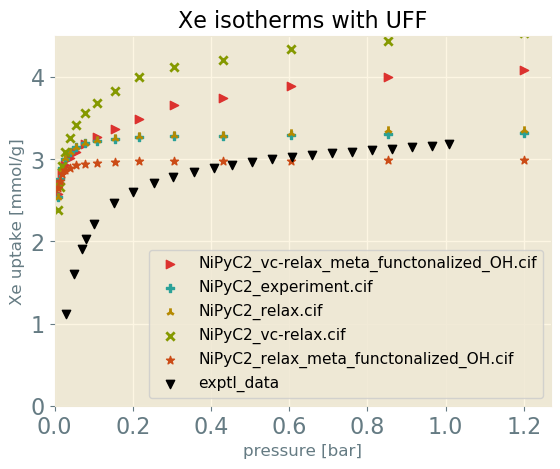

In [9]:
figure()
for cof in keys(cof_to_isotherm)
    scatter(cof_to_isotherm[cof][:, Symbol("pressure (bar)")], 
         cof_to_isotherm[cof][:, Symbol("⟨N⟩ (mmol/g)")], 
        label=cof, marker=cof_to_marker[cof],
        color=cof_to_color[cof])
end
scatter(df_xe_data[1:desorp_onset, Symbol("pressure (bar)")], 
         df_xe_data[1:desorp_onset, Symbol("⟨N⟩ (mmol/g)")], 
        label="exptl_data", marker="v", color="k")
legend(loc="best", fontsize="x-small")
xlabel("pressure [bar]")
ylabel("$adsorbate uptake [mmol/g]")
title("$adsorbate isotherms with $ffield")
xlim(xmin=0)
ylim(ymin=0, ymax=4.5)
savefig("$adsorbate _isotherms_with_ $ffield.png", format="png")

In [10]:
# figure()
# plot(cof_to_isotherm["NiPyC2_experiment.cif"][:, Symbol("pressure (bar)")], cof_to_isotherm["NiPyC2_experiment.cif"][:, Symbol("fugacity (bar)")], marker="o")
# plot([0, 1.2], [0, 1.2], color="k", linestyle="--")
# xlabel("pressure (bar)")
# ylabel("fugacity (bar)")
# title("fugacity versus pressure")

In [11]:
# const xe_critical_pressure = 58.420 # bar
# wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

# df_xe_data = CSV.read(wheres_nist_xenon_data)
# p_plot = range(0.0, 350.0, length=100)
# xe_vdw = VdWFluid(:Xe)
# xe_pr = PengRobinsonFluid(:Xe)
# ρ_vdw = [1.0 / calculate_properties(xe_vdw, 298.0, p, verbose=false)["molar volume (L/mol)"] for p in p_plot]
# ρ_pr = [1.0 / calculate_properties(xe_pr, 298.0, p, verbose=false)["molar volume (L/mol)"] for p in p_plot]

# figure()
# plot(p_plot, ρ_vdw, label="vdw EOS")
# plot(p_plot, ρ_pr, label="Peng-Robinson EOS")
# plot(df_xe_data[!, Symbol("Pressure (bar)")], df_xe_data[!, Symbol("Density (mol/l)")], label="NIST")
# axvline(x=xe_critical_pressure, linestyle="--", color="k", label="crit. pressure", lw=1)
# xlabel("pressure [bar]")
# ylabel("density [mol/L]")
# title("EOS Comparison")
# legend()

# # savefig("xenon_gas_density.png", format="png")